In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)

from scipy import special, optimize

########################################
def get_csv(filename):
    df = pd.read_csv(filename, delimiter=","); # Get CSV data
    units = df.iloc[0]; # Get units
    df = df.drop([0]); # Remove units row from dataframe
    
    #      [0]    [1]
    return units, df

### The Bird-Carreau-Yasuda Model [1]
### $$ \frac{\eta - \eta_{\infty}}{\eta_0 - \eta_{\infty}} = \frac{1}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} $$
### $$ \eta = \frac{\eta_0 - \eta_{\infty}}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} + \eta_{\infty} $$

### where:
$\eta =$ Viscosity <br>
$\dot{\gamma} =$ Shear rate <br>
$\eta_{\infty} =$ Infinite shear rate viscosity <br>
$\eta_0 =$ Zero shear rate viscosity <br>
$\kappa =$ Time constant <br>
$n =$ The Power Law index <br>
$a =$ The width of the transition region between the zero shear viscosity and the Power Law region

#### [1] Osswald, T., Rudolph, N., Osswald, T., & Rudolph, N. (2014). Generalized Newtonian Fluid (GNF) Models. Polymer Rheology, 59–99. https://doi.org/10.3139/9781569905234.003

In [2]:
def GNF_(gamma, eta_inft, eta_zero, kappa, n, a): # The Bird-Carreau-Yasuda Model Bird
    nume = eta_zero - eta_inft;
    
    base = 1 + (kappa*gamma)**a
    expo = (1 - n)/a
    deno = base**expo;
    
    return (nume/deno) + eta_inft

In [3]:
def fit_GNF_(filename, plotname, a):
    # Get units
    #units_df = get_csv("./csv/oskt 0_ps_thf.csv")[0]
    units_df = get_csv(filename)[0]

    # Get CSV data
    #nSeal_df = get_csv("./csv/oskt 0_ps_thf.csv")[1]
    nSeal_df = get_csv(filename)[1]

    # reasonable initial guesses for EOS parameters
    eta_inft = 0
    eta_zero = 1
    kappa    = 1
    n        = 0
    #a        = 9

    # # PRINT table with fittig parameters
    # tmplt_str_l = "  ".join(["{:<15}"] + ["{:<15}"]*5);
    # tmplt_str_s = "  ".join(["{:<15}"] + ["{:<15.7}"]*5);
    # print('')
    # print('Fitting:')
    # print(tmplt_str_l.format(*['parameters:', 'eta_inft', 'eta_zero', 'kappa', 'n', 'a']));
    # print("-" * 96);

    # Chose what to plot
    x_index = 1; # gamma = Shear rate
    y_index = 2; # eta   = Viscosity

    # Optimization process
    gamma = nSeal_df.iloc[:, x_index].to_numpy().astype(np.float);
    eta   = nSeal_df.iloc[:, y_index].to_numpy().astype(np.float);
    
    #print(gamma, eta)
    
    #eta_prev = GNF_(gamma, eta_inft, eta_zero, kappa, n, a);

    # remove neg values
    gamma = gamma[eta >= 0]
    eta = eta[eta >= 0]

    p0 = eta_inft, eta_zero, kappa, n, a;
    results = optimize.curve_fit(GNF_, gamma, eta, p0)

    eta_inft = results[0][0];
    eta_zero = results[0][1];
    kappa    = results[0][2];
    n        = results[0][3];
    a        = results[0][4];
    
    gamma_fit = gamma #np.linspace(minX, maxX, 1000); #gamma
    eta_fit = GNF_(gamma_fit, eta_inft, eta_zero, kappa, n, a)

    # # PRINT table with fittig parameters
    # print(tmplt_str_s.format('Fit curve', *results[0], 0));

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));

    # Plot
    plt.scatter(gamma, eta, s=25, color='red', label='Collected data');
    plt.plot(gamma, eta, linewidth=0.125, color='red');
    plt.plot(gamma_fit, eta_fit, '-', linewidth=3, label='Fitted curve');

    # Print fitting parameters as plot legends
    x = gamma[0]
    y = eta[0]
    plt.scatter(x, y, s=0, label=' ')
    plt.scatter(x, y, s=0, label=r'$\eta_{\infty} = $' + str(round(eta_inft, 6)) + r' $Pa \cdot s$')
    plt.scatter(x, y, s=0, label=r'$\eta_0 = $' + str(round(eta_zero, 6)) + r' $Pa \cdot s$')
    #plt.scatter(x, y, s=0, label=r'$\kappa = $' + str(round(kappa, 6)))
    #plt.scatter(x, y, s=0, label=r'$n = $' + str(round(n, 6)))
    #plt.scatter(x, y, s=0, label=r'$a = $' + str(round(a, 6)))

    # Display plots
    plt.yscale('log');
    plt.xscale('log');
    plt.xlabel(str(nSeal_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
    plt.ylabel(str(nSeal_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 18});
    display(plt);

In [4]:
def compareData_(plotname, filemanes, plotlabels):
    
    # Get units
    units_df = get_csv(filemanes[0])[0]
    display(units_df)

    # Draw plot canvas
    scale = 6;
    plt.subplots(figsize=(3*scale, 2*scale));

    # Chose what to plot
    x_index = 1
    y_index = 2

    # Plot
    for i in range(len(filemanes)):
        _0_ps_thf_df = get_csv(filemanes[i])[1]
        x = _0_ps_thf_df.iloc[:, x_index].to_numpy().astype(np.float)
        y = _0_ps_thf_df.iloc[:, y_index].to_numpy().astype(np.float)
        plt.scatter(x, y, s=(i*5)+5, label=plotlabels[i]);
        plt.plot(x, y, linewidth=0.125);
        minY = min(y)
        maxY = max(y)
    
    # Display plots
    plt.yscale('log');
    plt.xscale('log');
    plt.xlabel(str(_0_ps_thf_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
    plt.ylabel(str(_0_ps_thf_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
    plt.title(plotname, size=24);
    plt.legend(prop={'size': 18});
    display(plt);

---

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

Stress            MPa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress     MPa
Name: 0, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

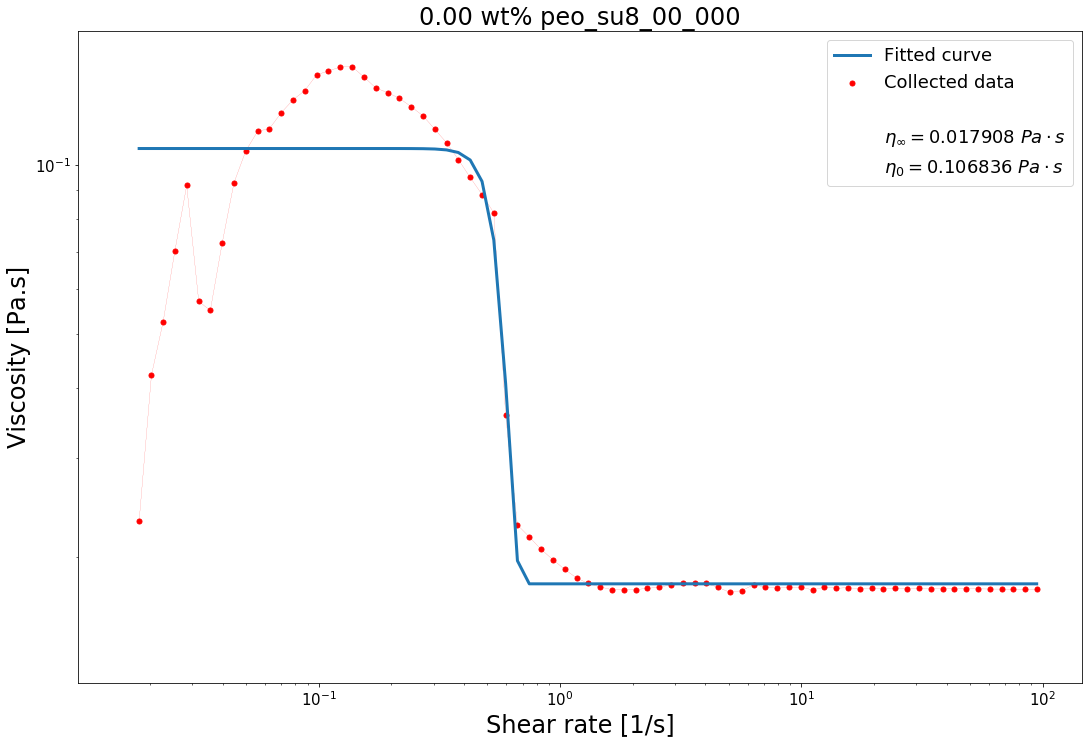

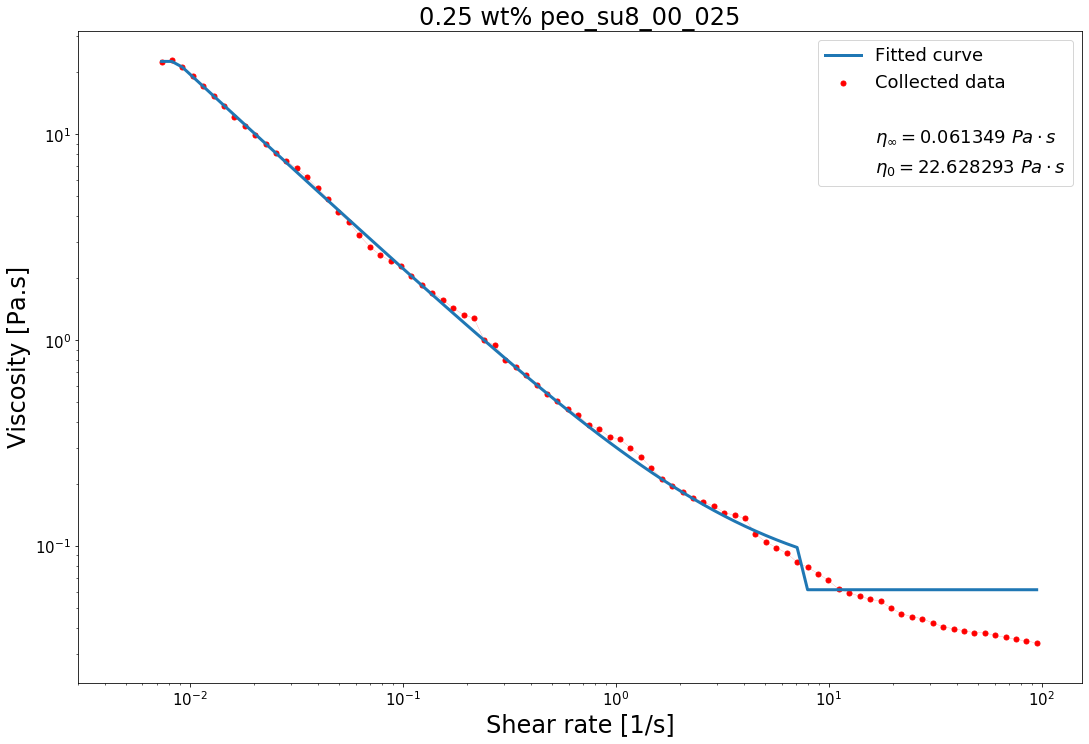

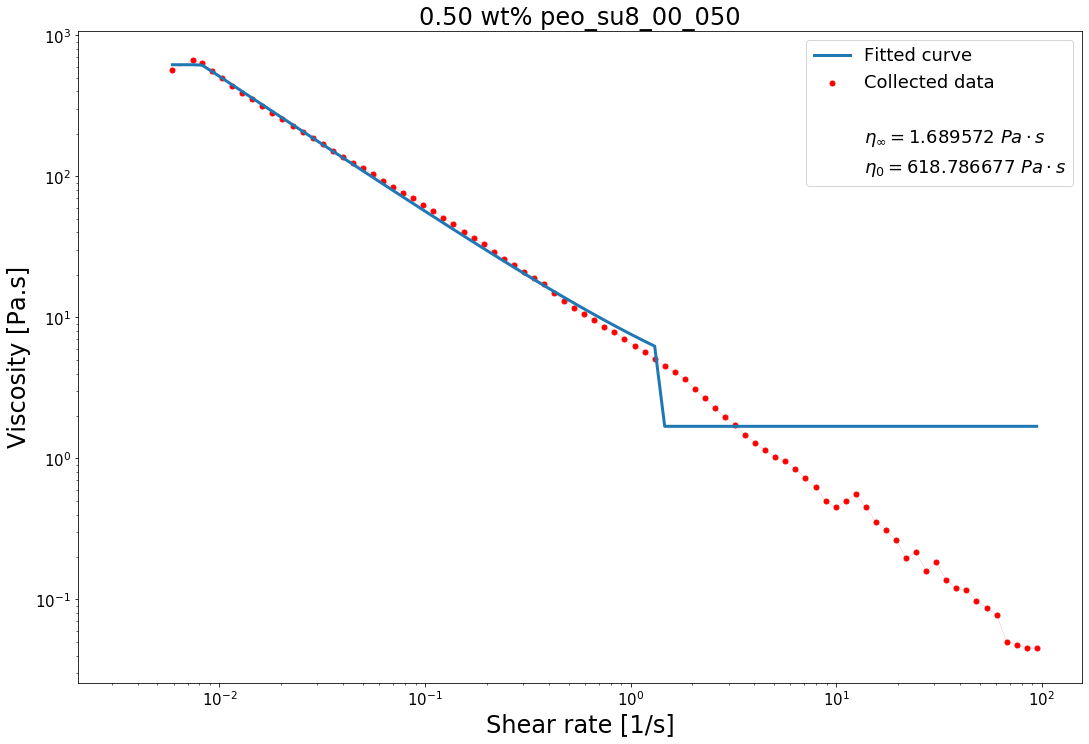

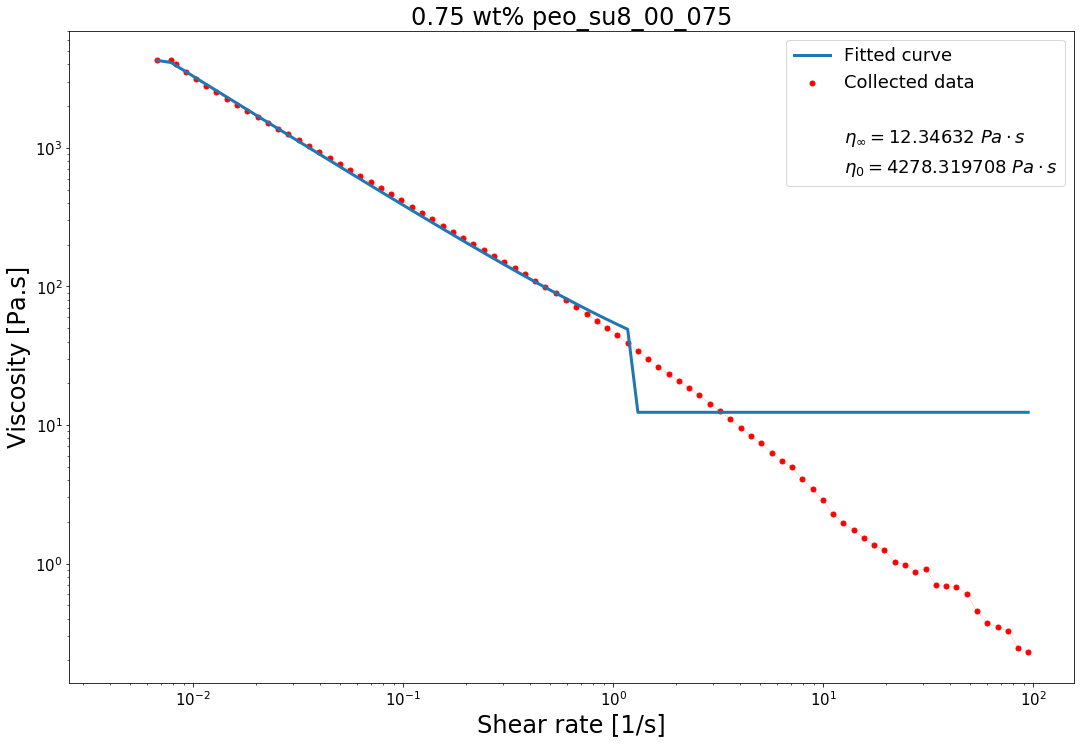

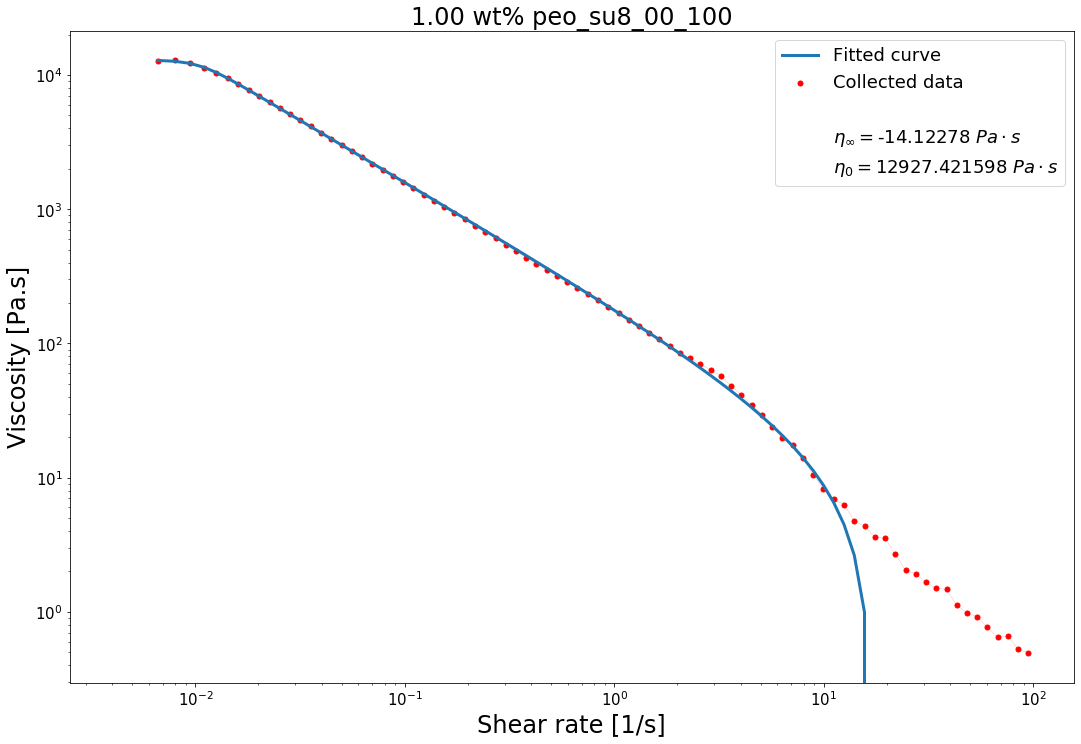

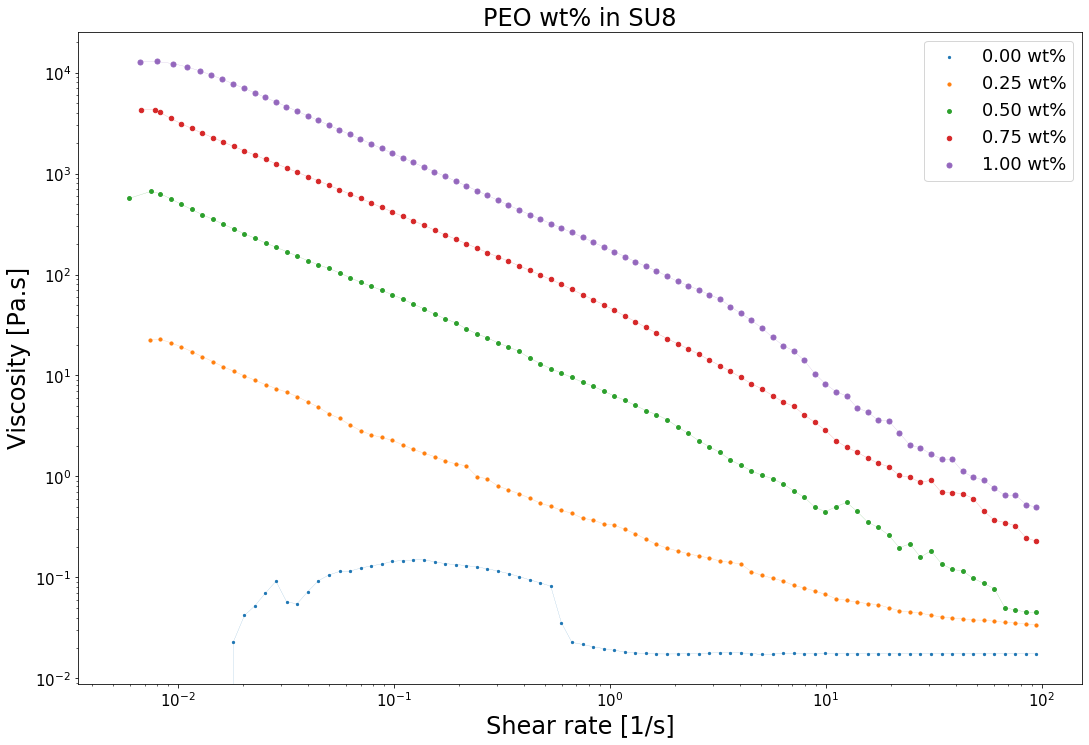

In [5]:
fit_GNF_("./csv/peo_su8_00_000.csv", "0.00 wt% peo_su8_00_000", 2)
fit_GNF_("./csv/peo_su8_00_025.csv", "0.25 wt% peo_su8_00_025", 1)
fit_GNF_("./csv/peo_su8_00_050.csv", "0.50 wt% peo_su8_00_050", 1)
fit_GNF_("./csv/peo_su8_00_075.csv", "0.75 wt% peo_su8_00_075", 1)
fit_GNF_("./csv/peo_su8_00_100.csv", "1.00 wt% peo_su8_00_100", 1)

compareData_("PEO wt% in SU8",
[
    "./csv/peo_su8_00_000.csv",
    "./csv/peo_su8_00_025.csv",
    "./csv/peo_su8_00_050.csv",
    "./csv/peo_su8_00_075.csv",
    "./csv/peo_su8_00_100.csv"
], [
    "0.00 wt%",
    "0.25 wt%",
    "0.50 wt%",
    "0.75 wt%",
    "1.00 wt%"
])

---

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

Stress            MPa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress     MPa
Name: 0, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

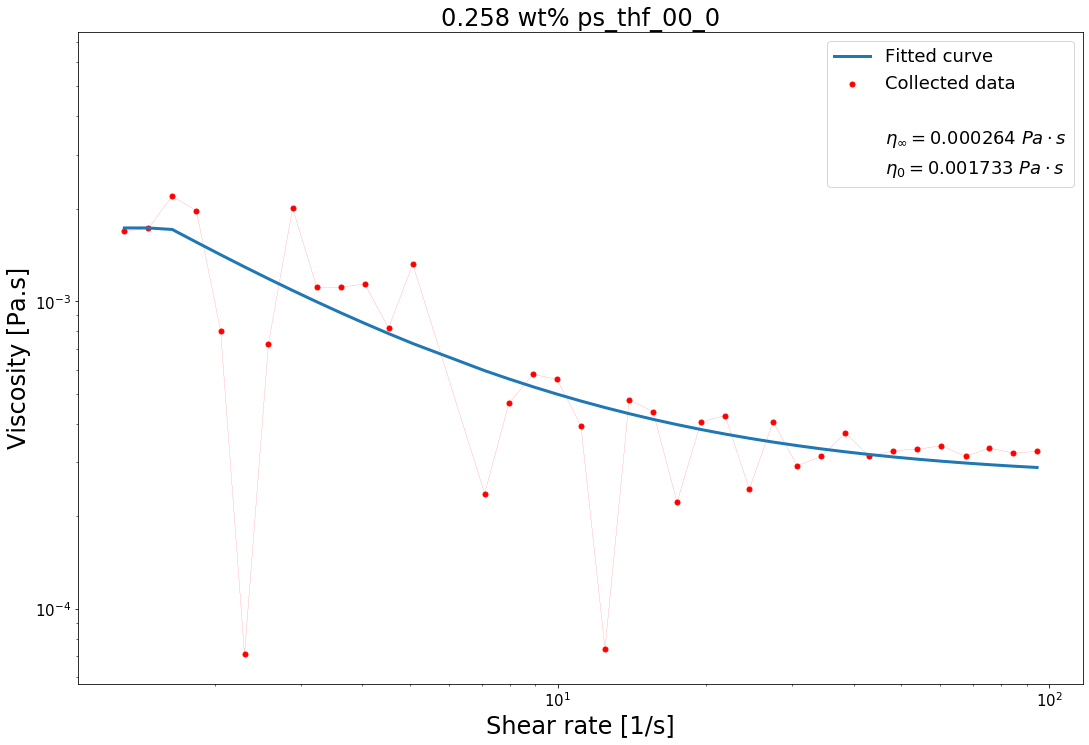

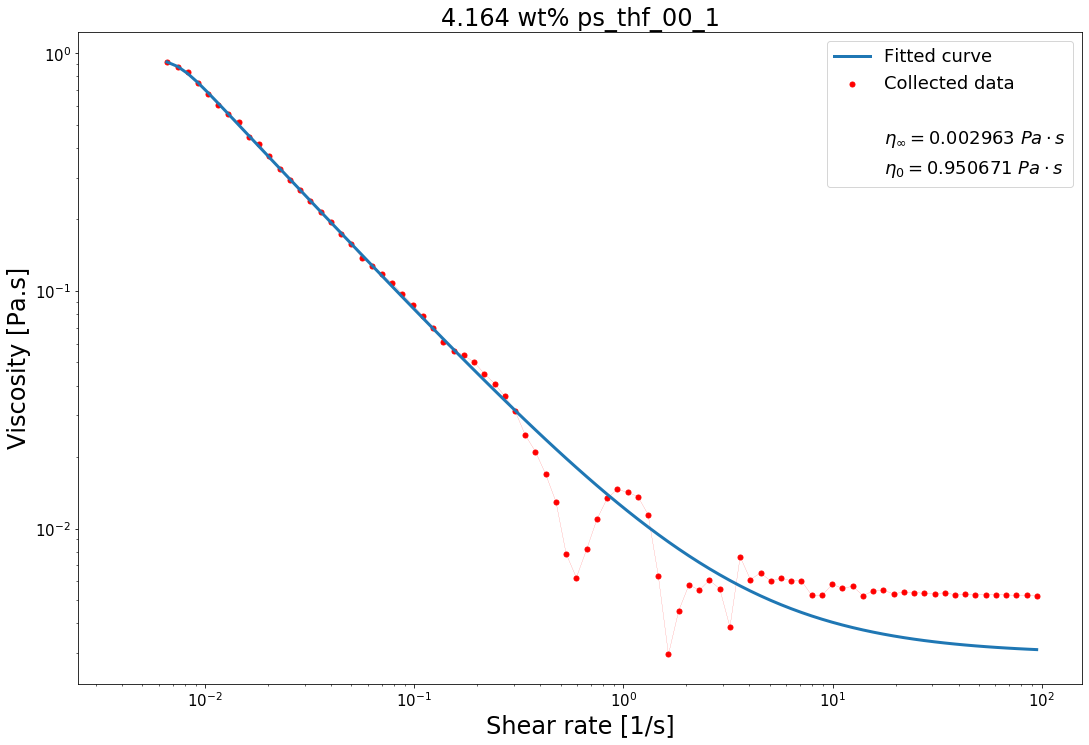

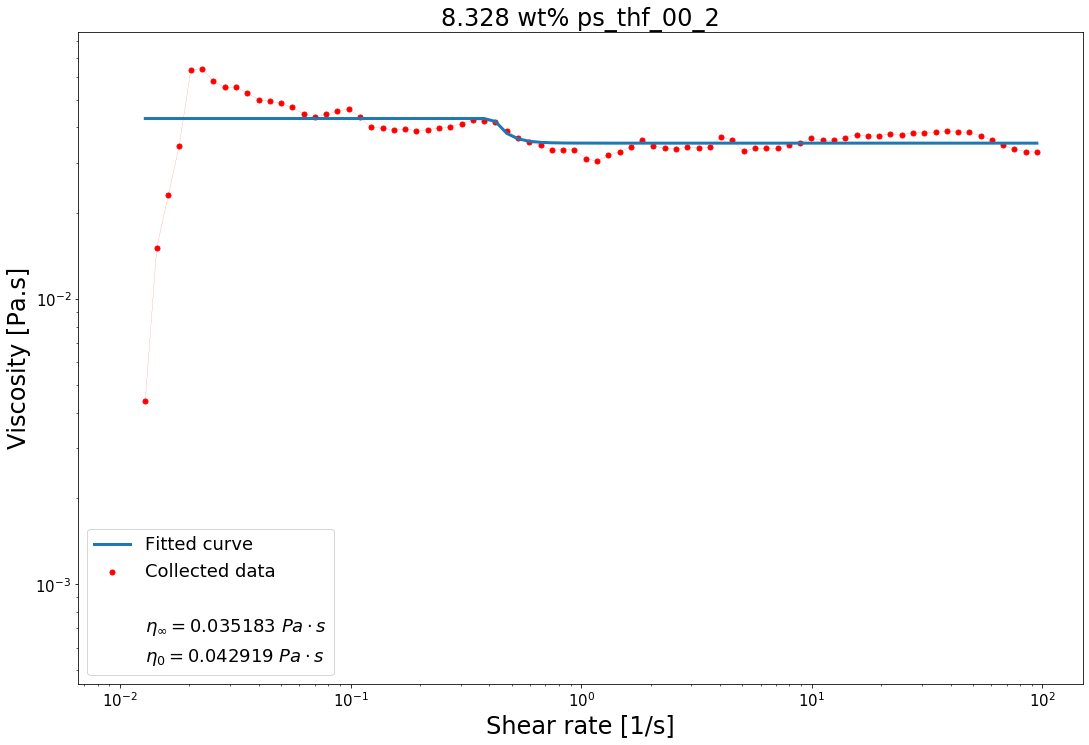

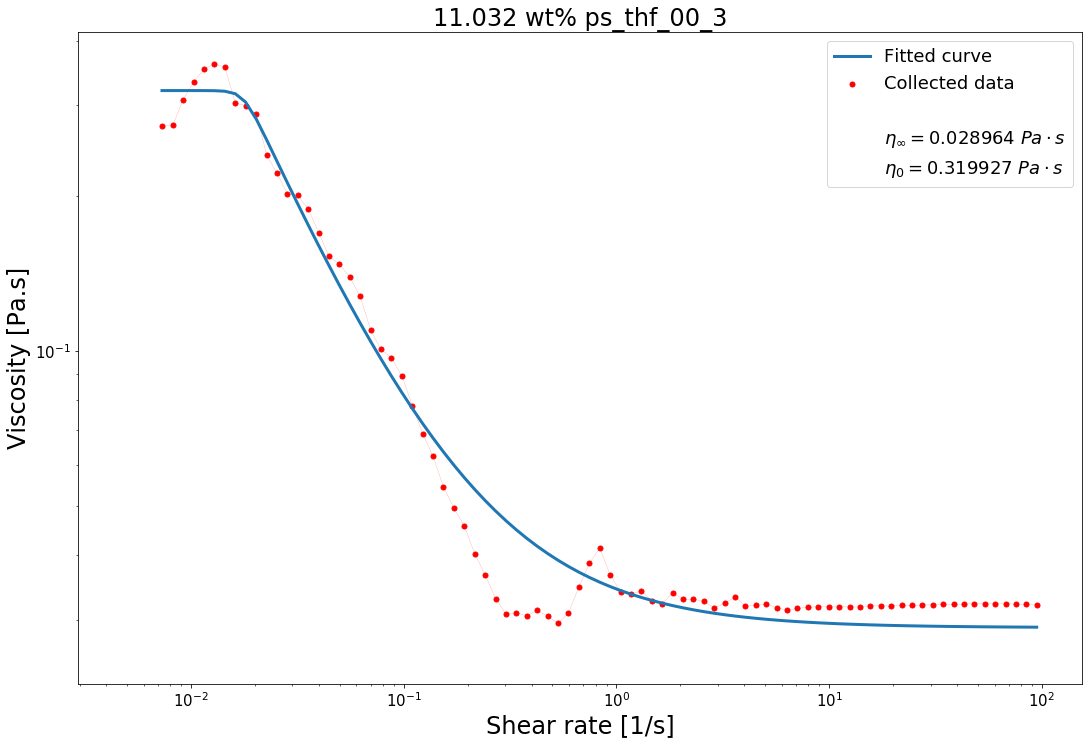

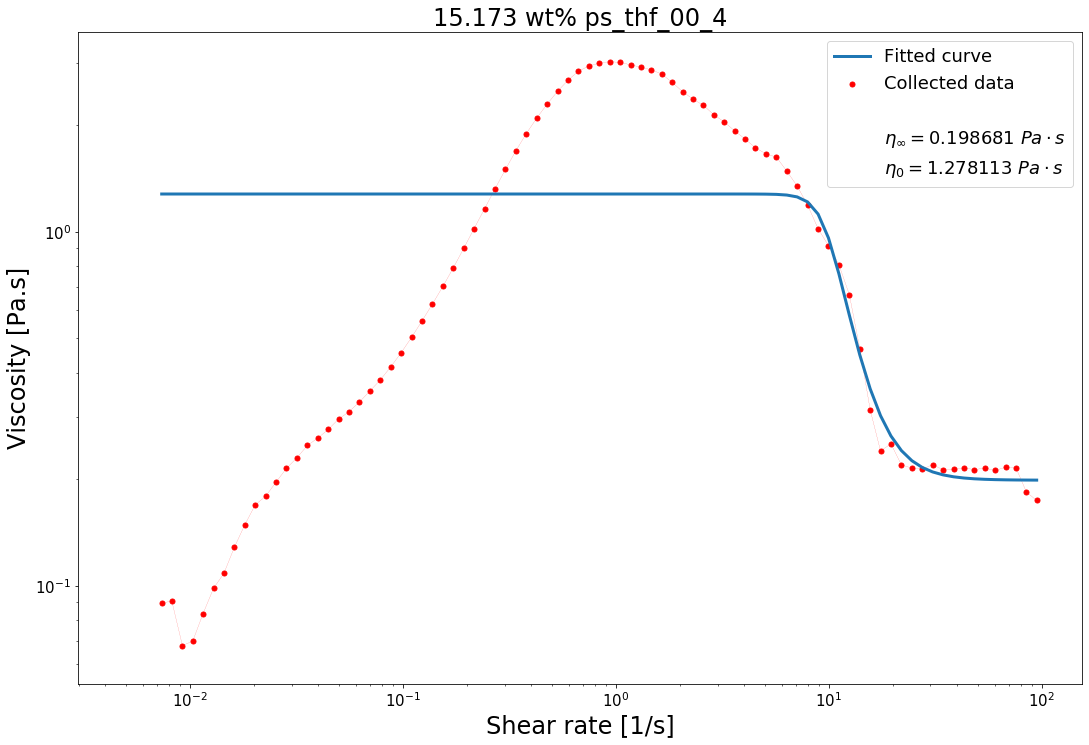

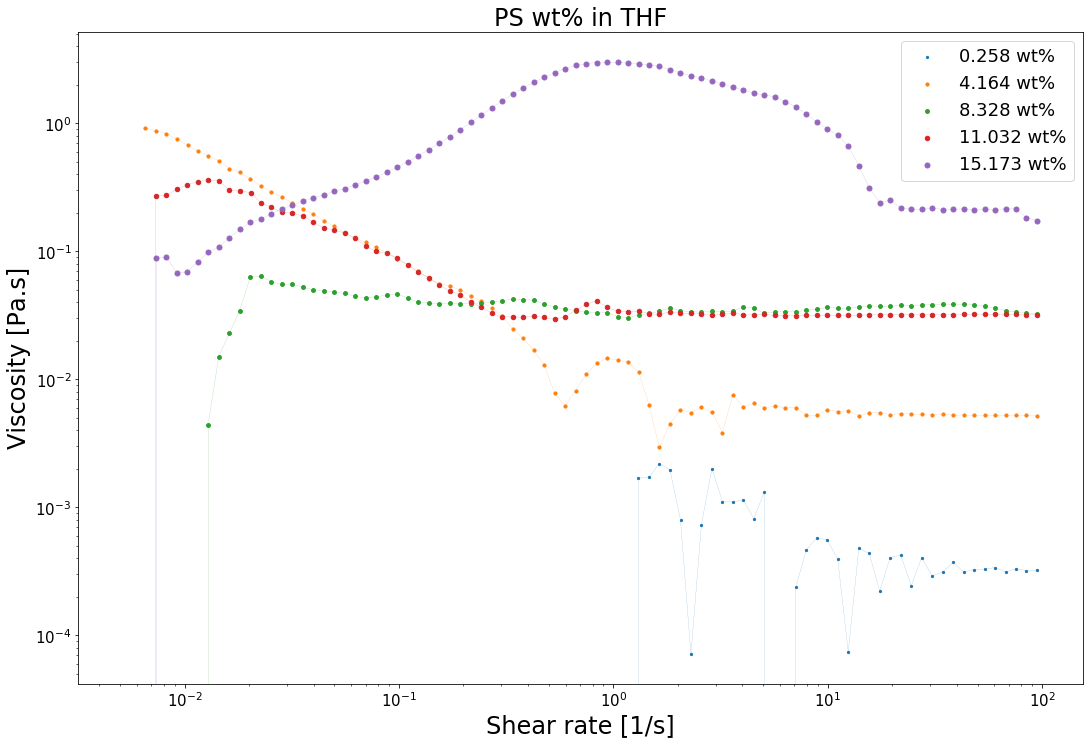

In [6]:
fit_GNF_("./csv/ps_thf_00_0.csv", "0.258 wt% ps_thf_00_0",  9)
fit_GNF_("./csv/ps_thf_00_1.csv", "4.164 wt% ps_thf_00_1",  2)
fit_GNF_("./csv/ps_thf_00_2.csv", "8.328 wt% ps_thf_00_2",  700)
fit_GNF_("./csv/ps_thf_00_3.csv", "11.032 wt% ps_thf_00_3", 1)
fit_GNF_("./csv/ps_thf_00_4.csv", "15.173 wt% ps_thf_00_4", 1)

compareData_("PS wt% in THF",
[
    "./csv/ps_thf_00_0.csv",
    "./csv/ps_thf_00_1.csv",
    "./csv/ps_thf_00_2.csv",
    "./csv/ps_thf_00_3.csv",
    "./csv/ps_thf_00_4.csv"
], [
    "0.258 wt%",
    "4.164 wt%",
    "8.328 wt%",
    "11.032 wt%",
    "15.173 wt%"
])

---

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

Stress            MPa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress     MPa
Name: 0, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

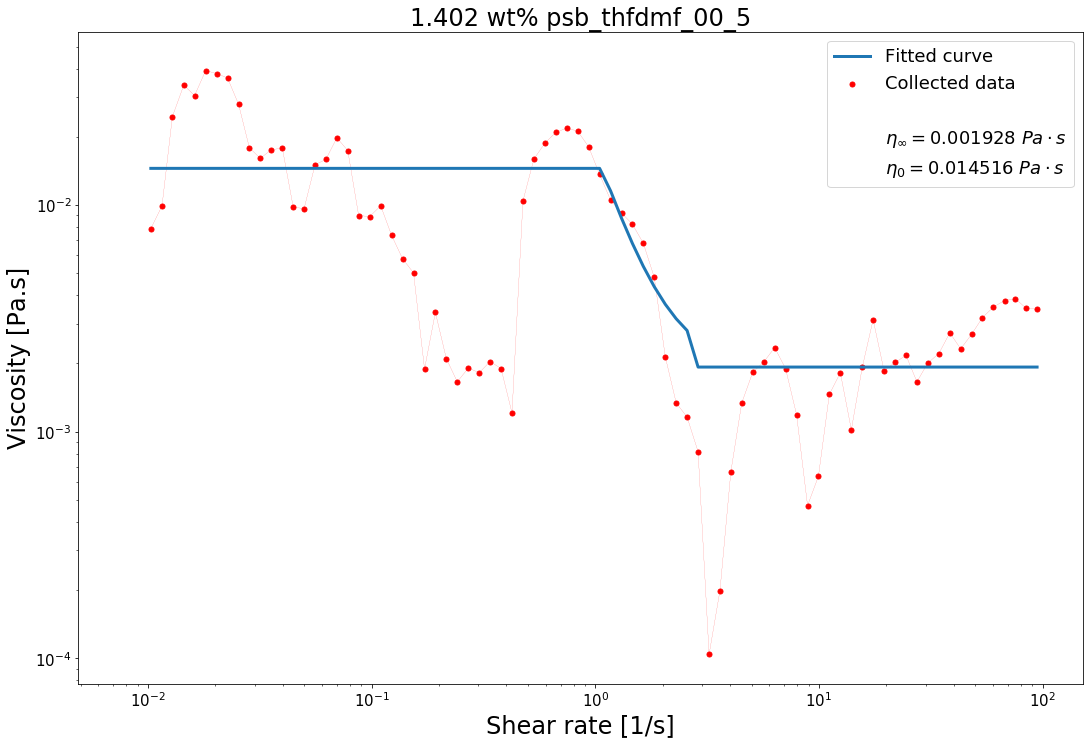

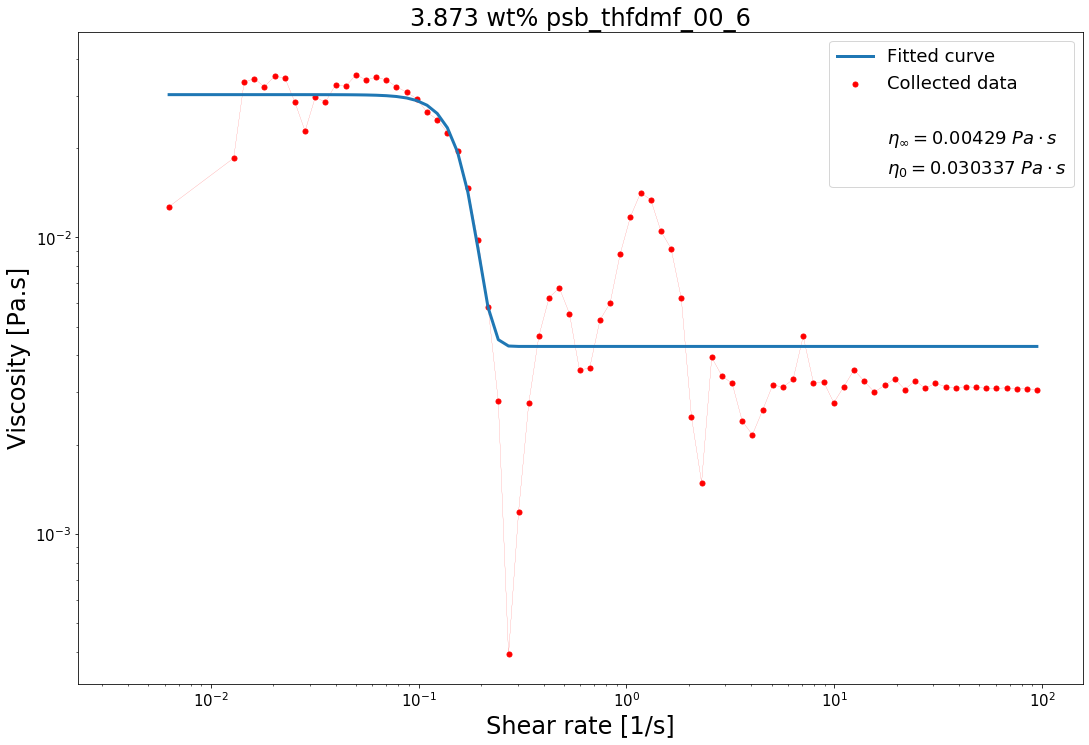

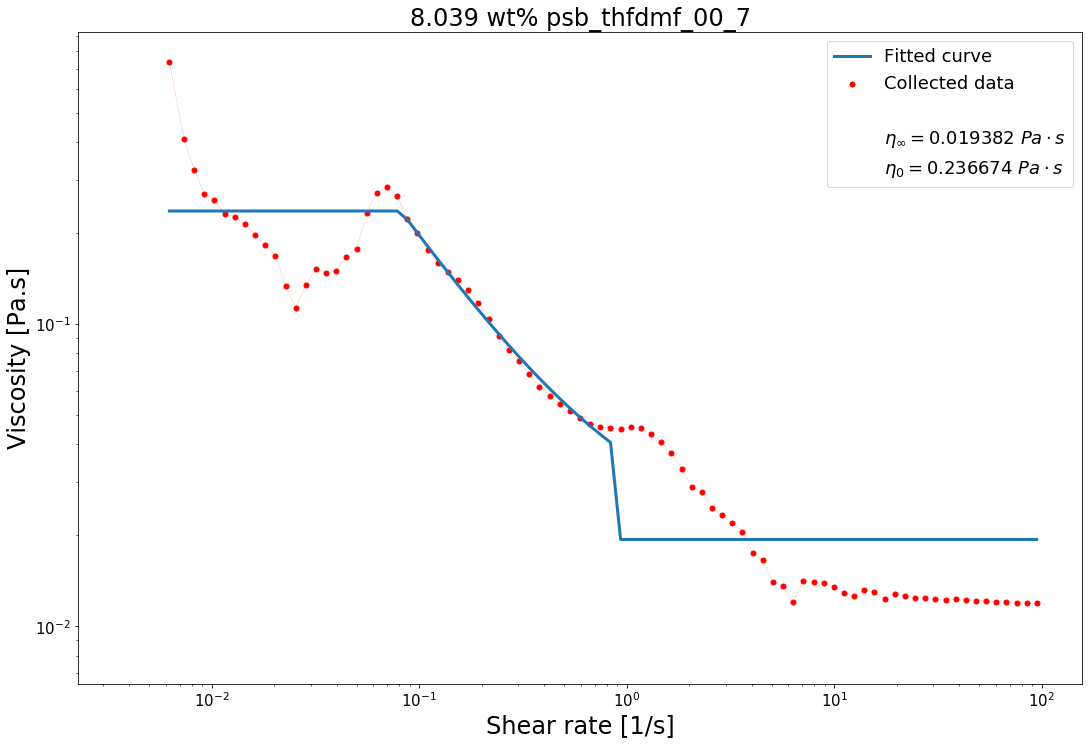

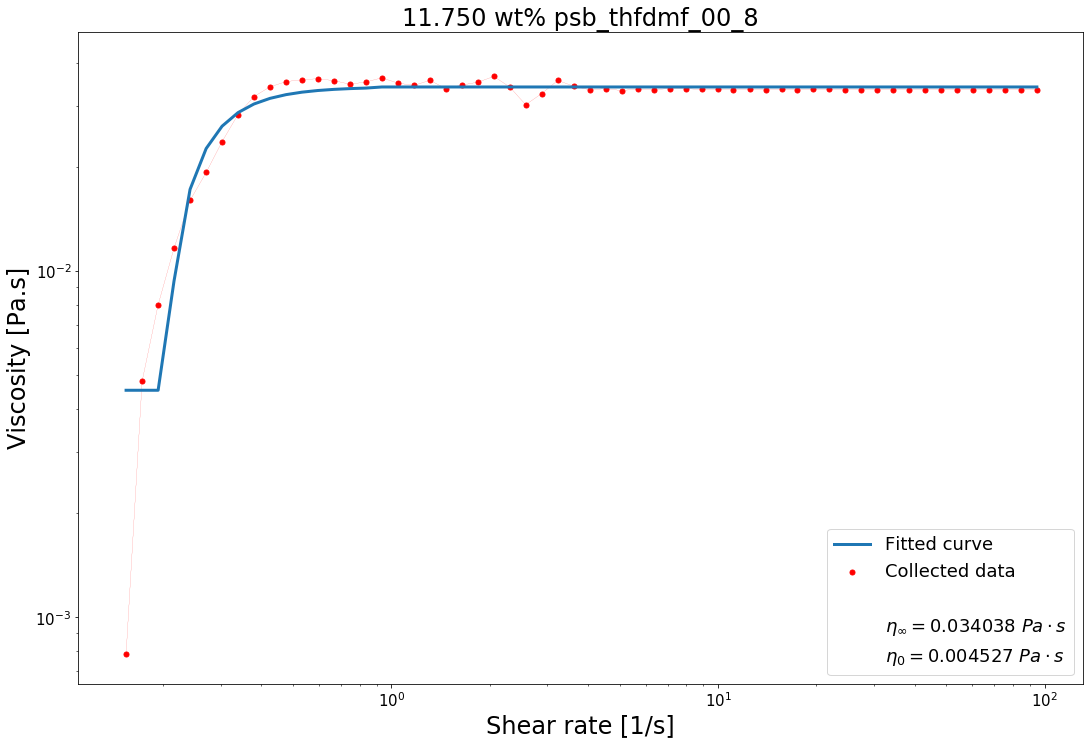

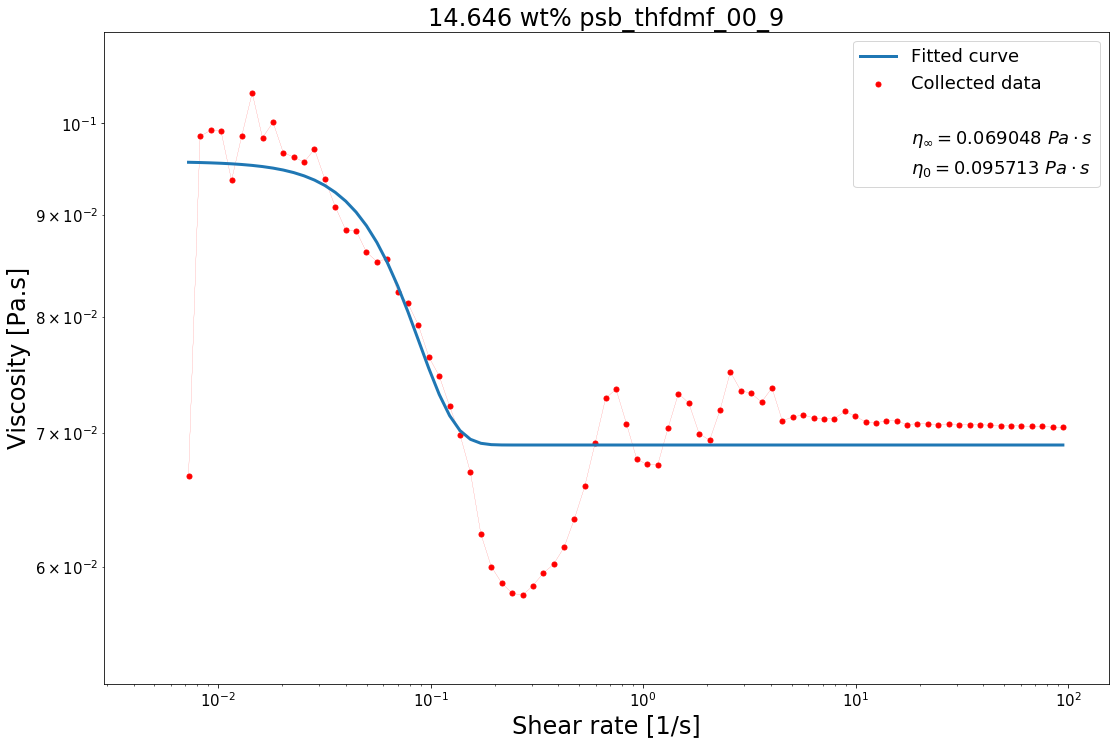

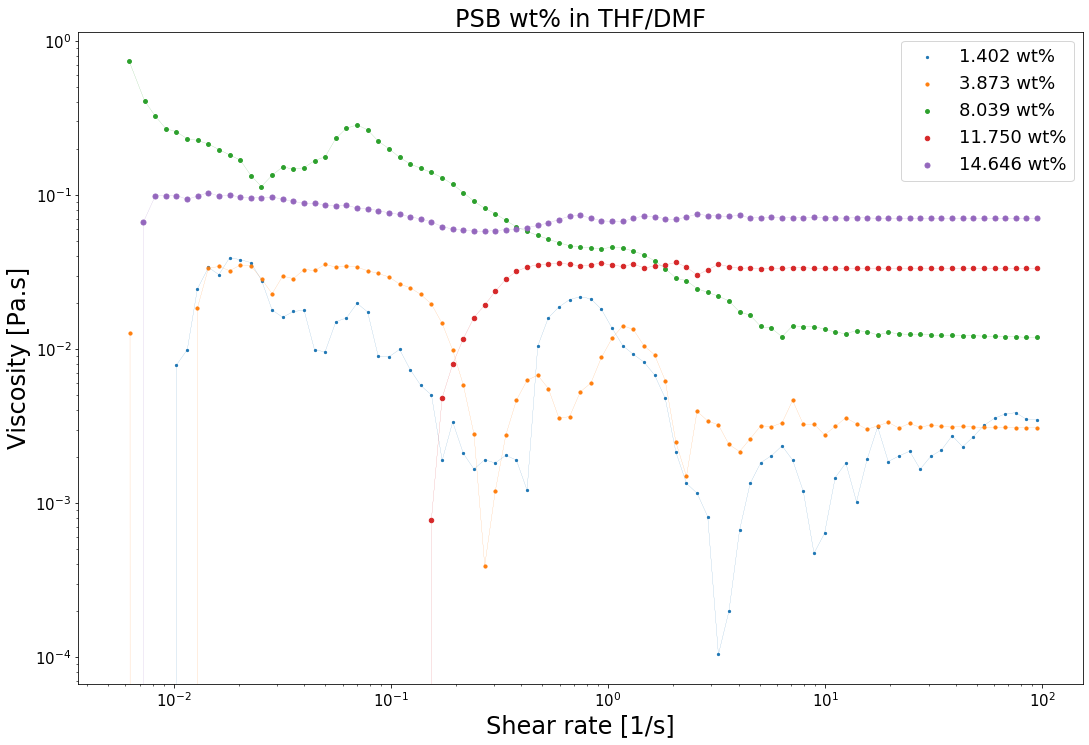

In [7]:
fit_GNF_("./csv/psb_thfdmf_00_5.csv", "1.402 wt% psb_thfdmf_00_5",  800)
fit_GNF_("./csv/psb_thfdmf_00_6.csv", "3.873 wt% psb_thfdmf_00_6",  1)
fit_GNF_("./csv/psb_thfdmf_00_7.csv", "8.039 wt% psb_thfdmf_00_7",  400)
fit_GNF_("./csv/psb_thfdmf_00_8.csv", "11.750 wt% psb_thfdmf_00_8", 500)
fit_GNF_("./csv/psb_thfdmf_00_9.csv", "14.646 wt% psb_thfdmf_00_9", 1)

compareData_("PSB wt% in THF/DMF",
[
    "./csv/psb_thfdmf_00_5.csv",
    "./csv/psb_thfdmf_00_6.csv",
    "./csv/psb_thfdmf_00_7.csv",
    "./csv/psb_thfdmf_00_8.csv",
    "./csv/psb_thfdmf_00_9.csv"
], [
    "1.402 wt%",
    "3.873 wt%",
    "8.039 wt%",
    "11.750 wt%",
    "14.646 wt%"
])

---

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

Stress            MPa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress     MPa
Name: 0, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

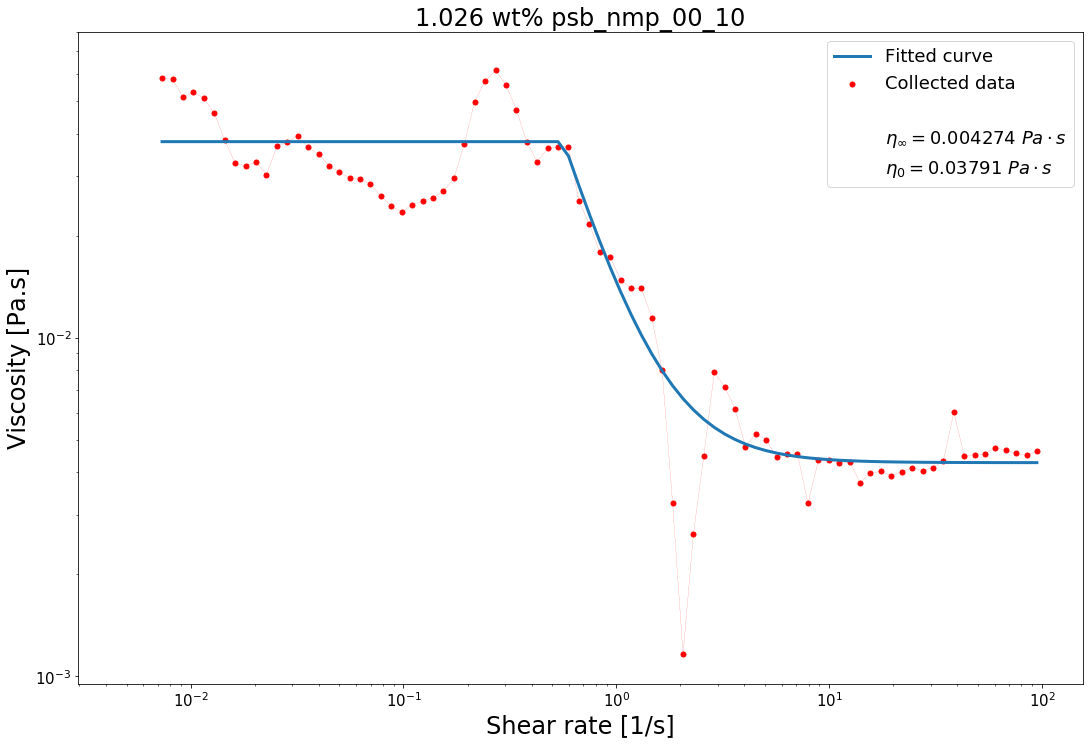

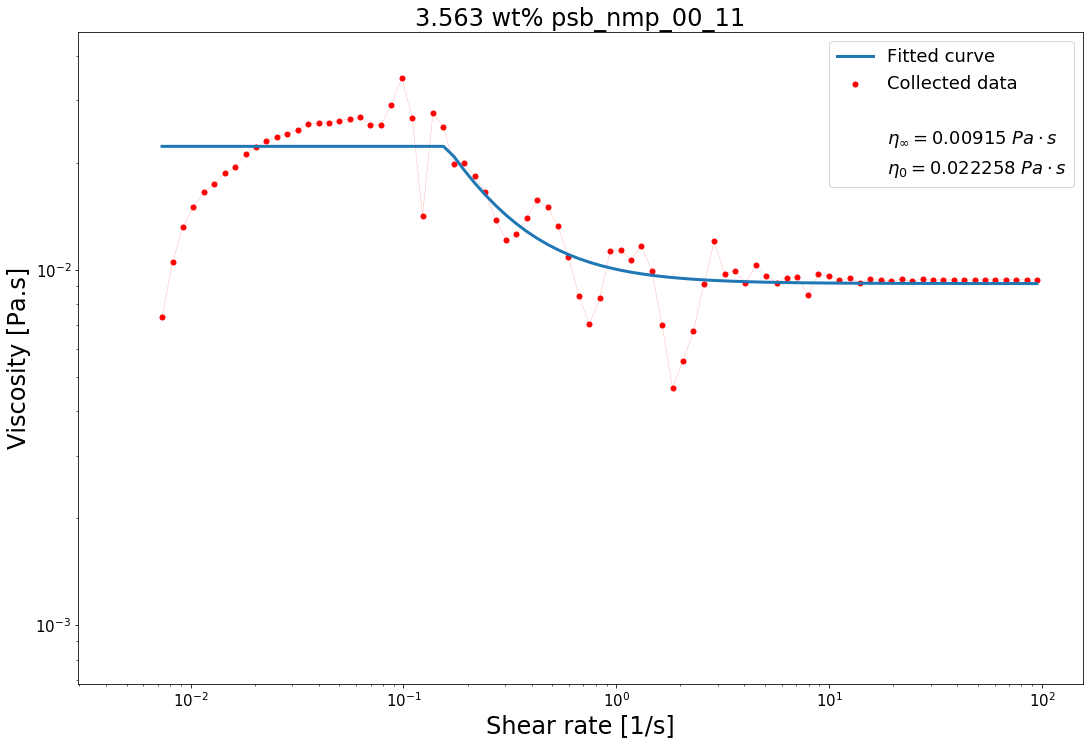

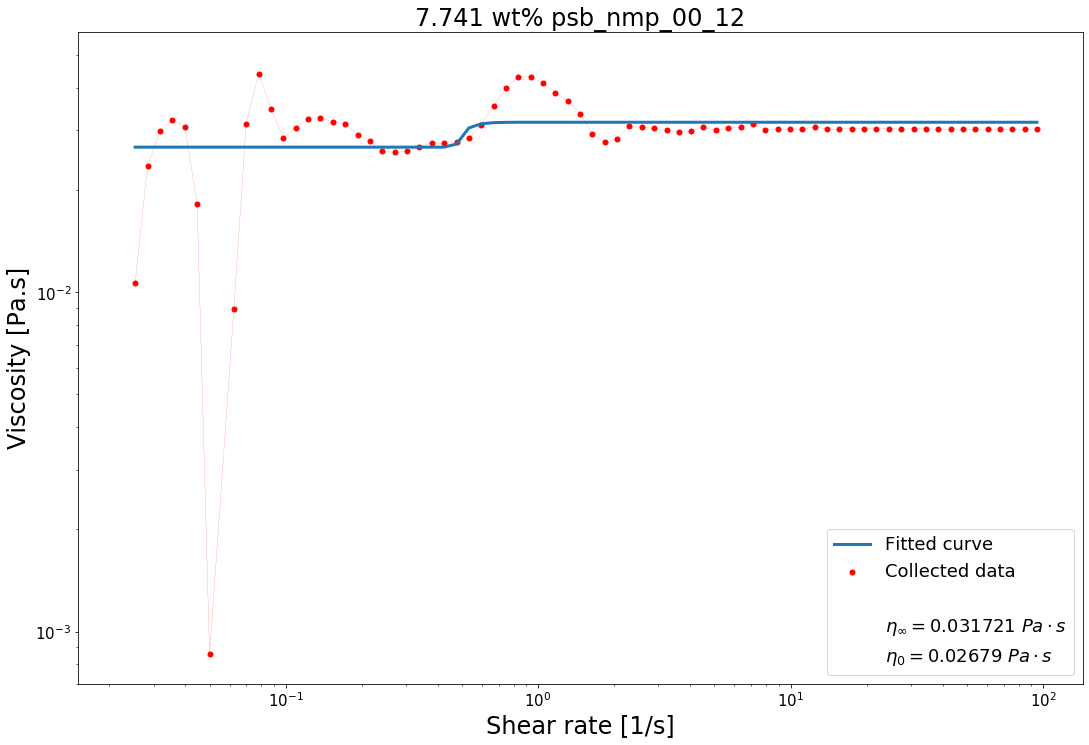

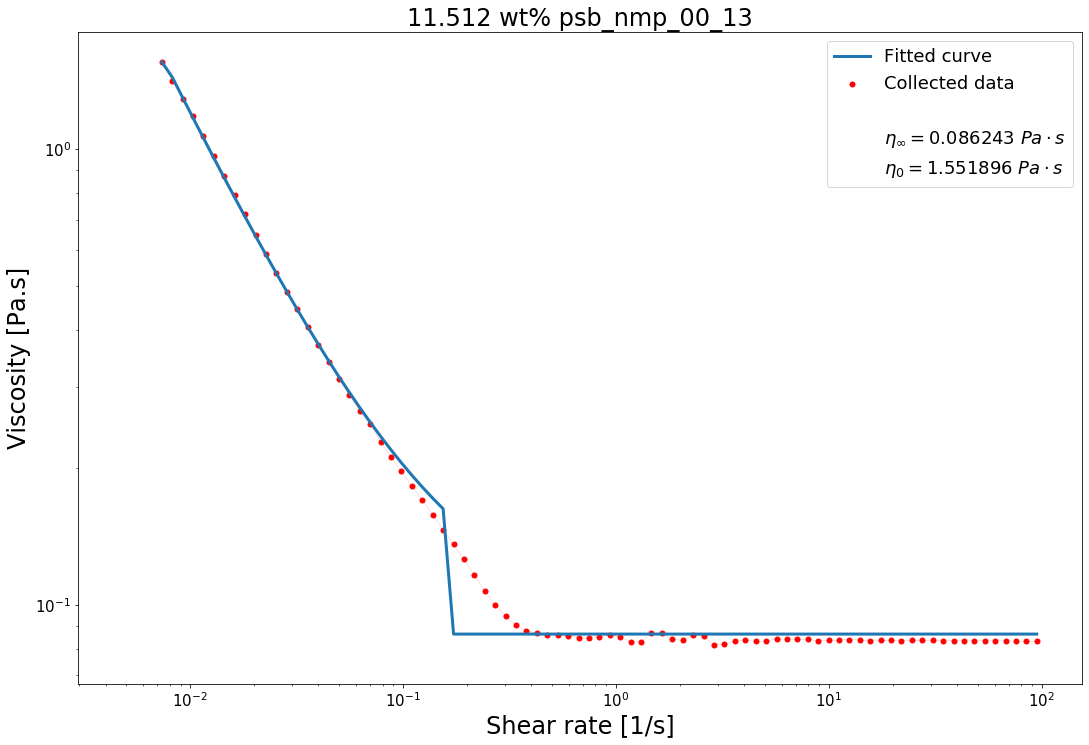

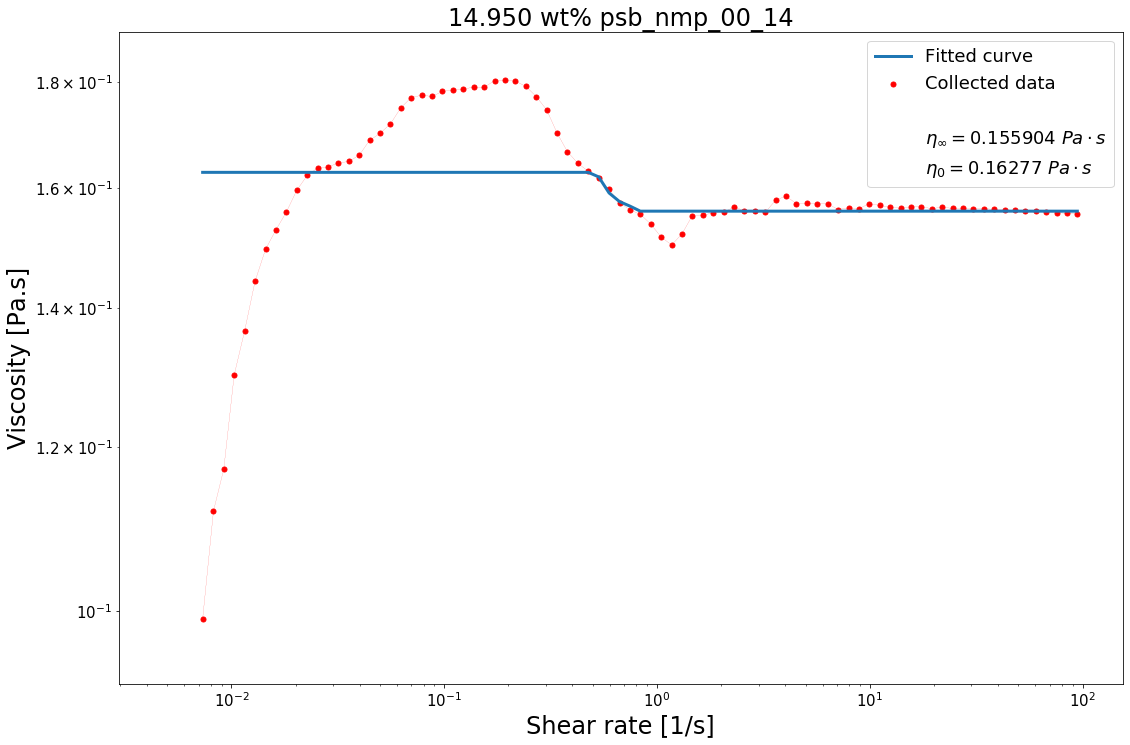

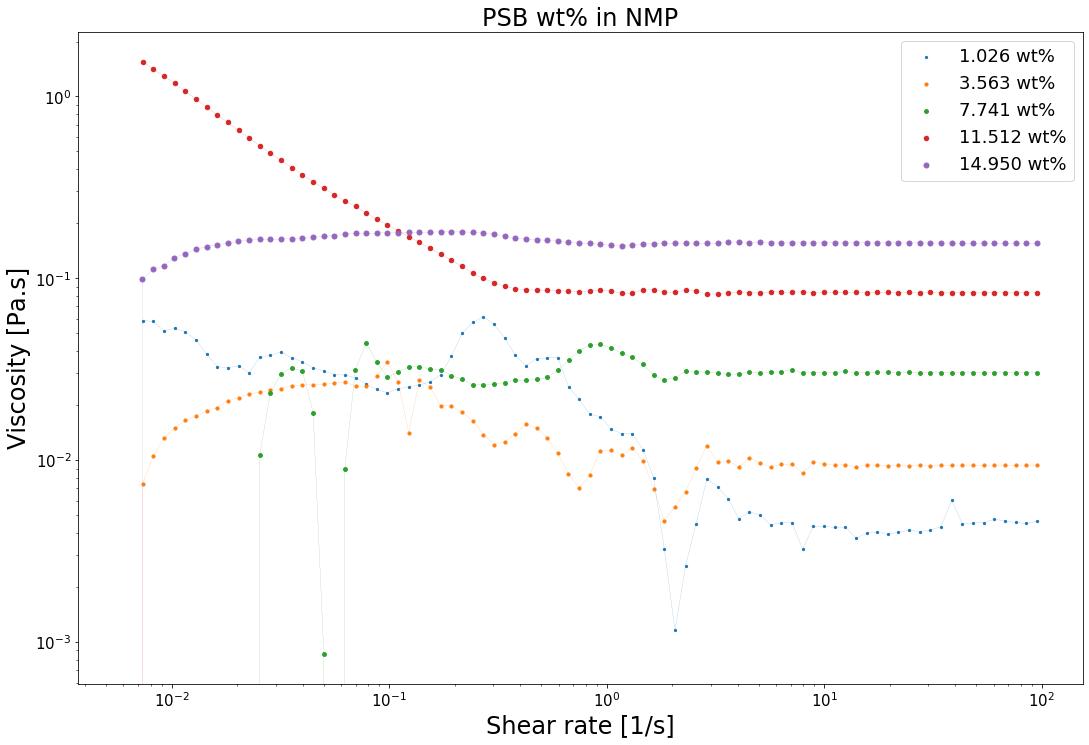

In [8]:
fit_GNF_("./csv/psb_nmp_00_10.csv", "1.026 wt% psb_nmp_00_10",  1)
fit_GNF_("./csv/psb_nmp_00_11.csv", "3.563 wt% psb_nmp_00_11",  1)
fit_GNF_("./csv/psb_nmp_00_12.csv", "7.741 wt% psb_nmp_00_12",  100)
fit_GNF_("./csv/psb_nmp_00_13.csv", "11.512 wt% psb_nmp_00_13", 990)
fit_GNF_("./csv/psb_nmp_00_14.csv", "14.950 wt% psb_nmp_00_14", 1500)

compareData_("PSB wt% in NMP",
[
    "./csv/psb_nmp_00_10.csv",
    "./csv/psb_nmp_00_11.csv",
    "./csv/psb_nmp_00_12.csv",
    "./csv/psb_nmp_00_13.csv",
    "./csv/psb_nmp_00_14.csv"
], [
    "1.026 wt%",
    "3.563 wt%",
    "7.741 wt%",
    "11.512 wt%",
    "14.950 wt%"
])

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

Stress             Pa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress      Pa
Name: 0, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

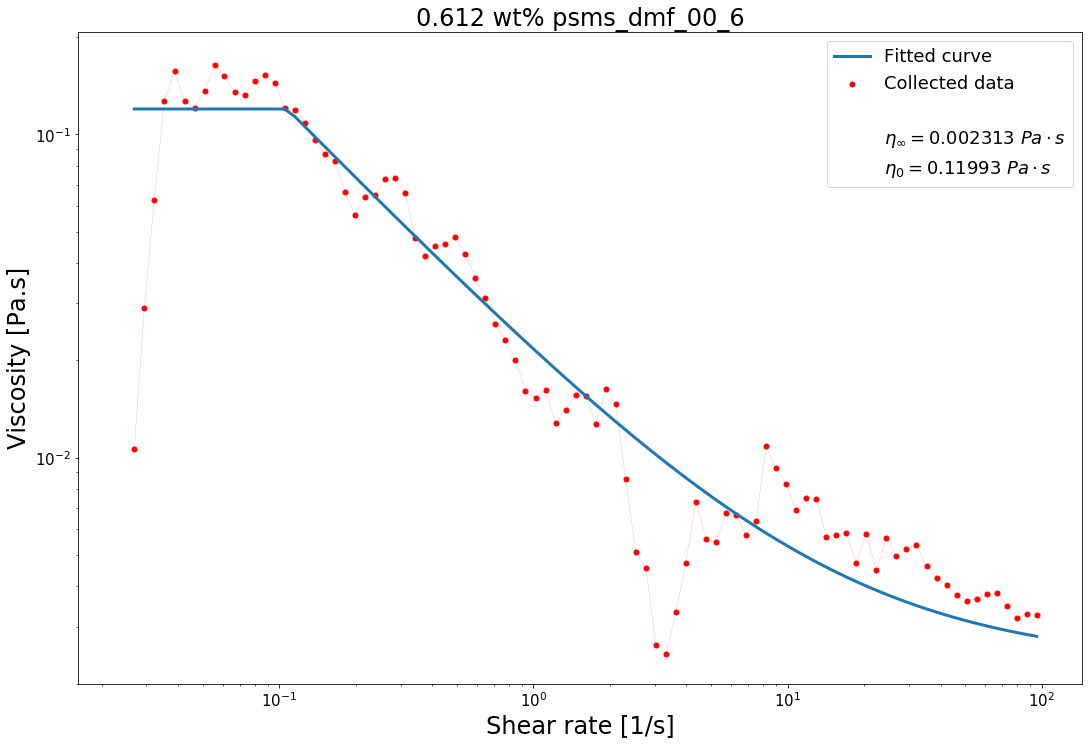

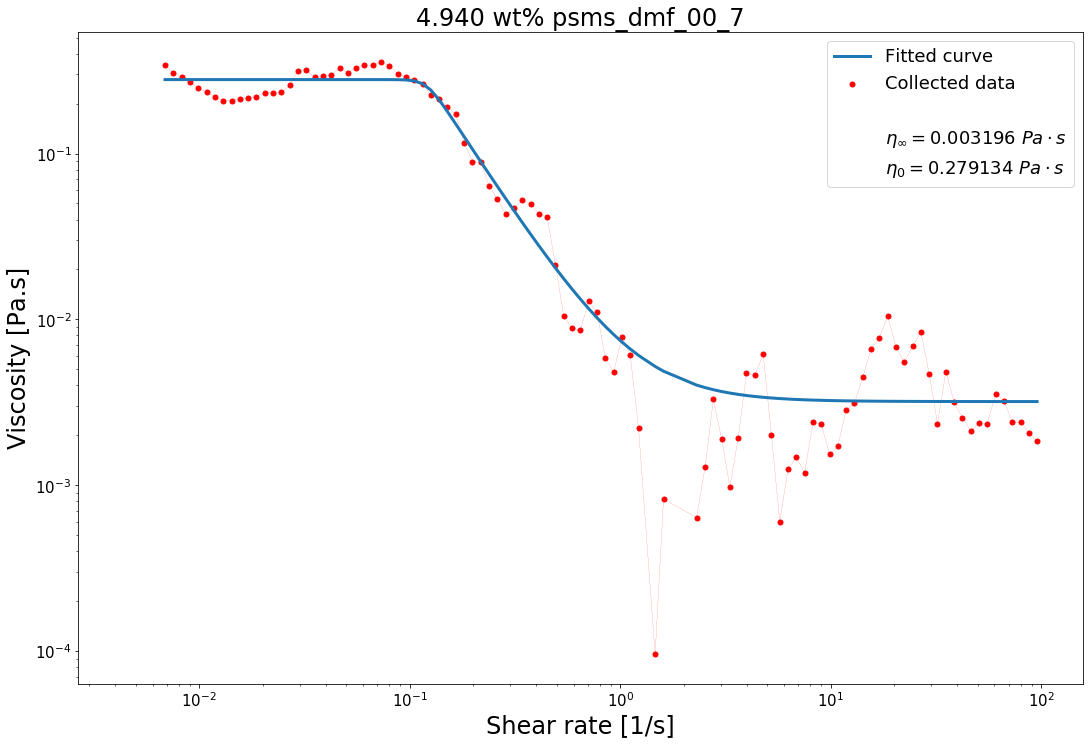

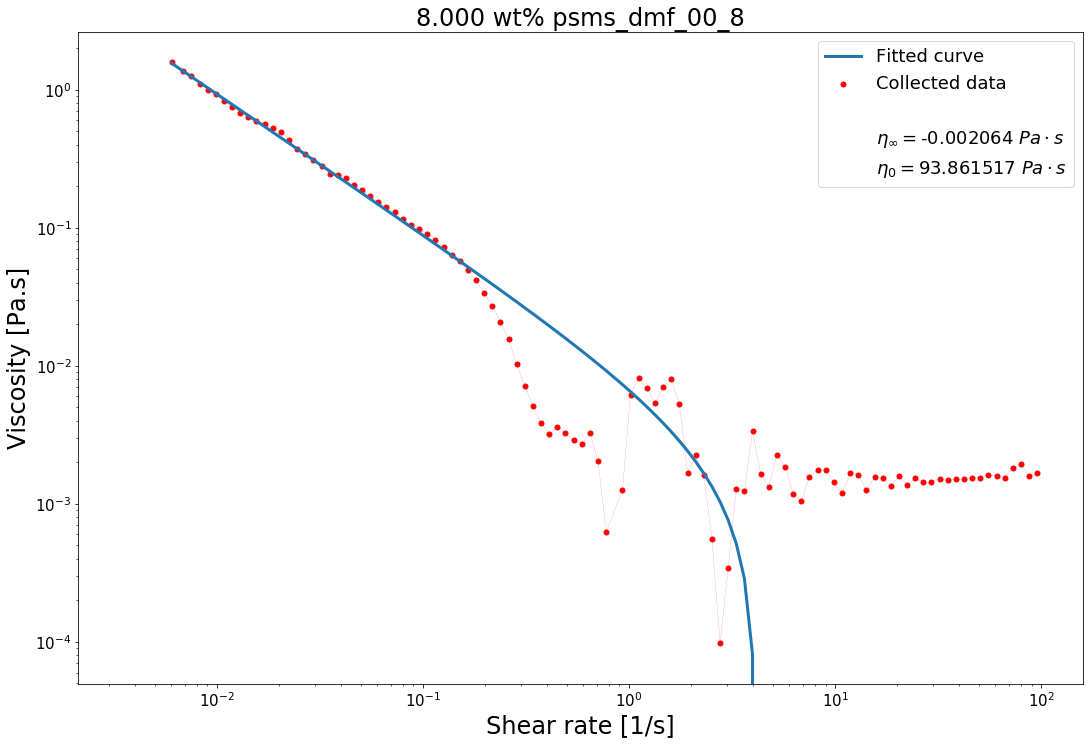

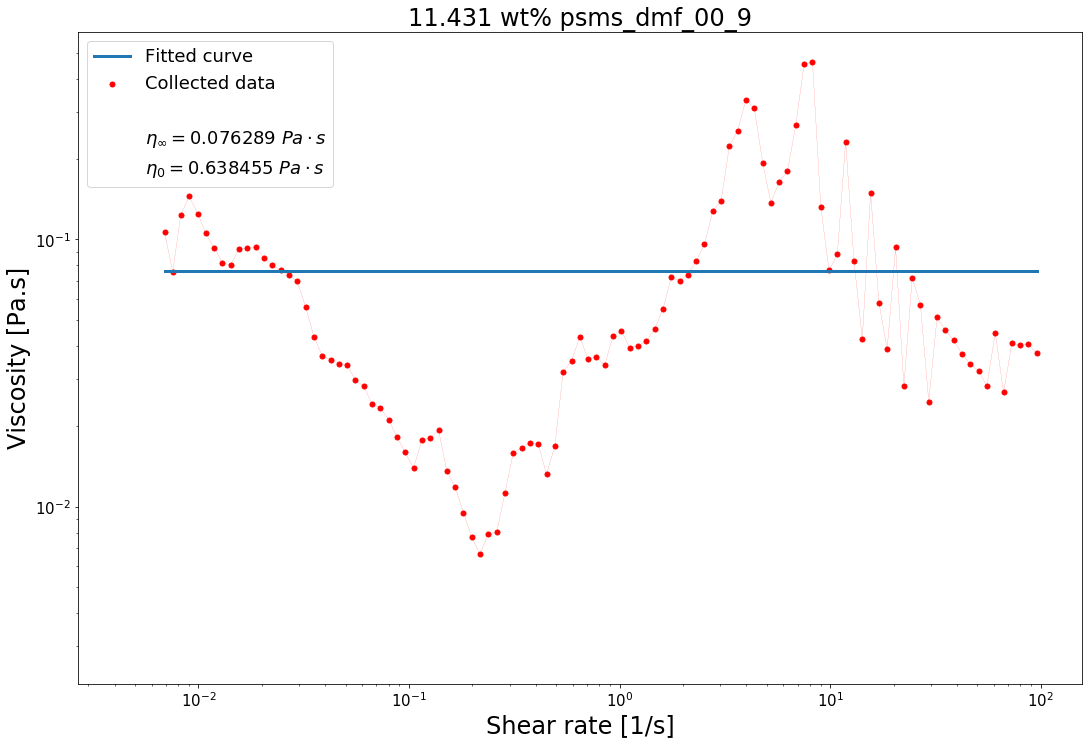

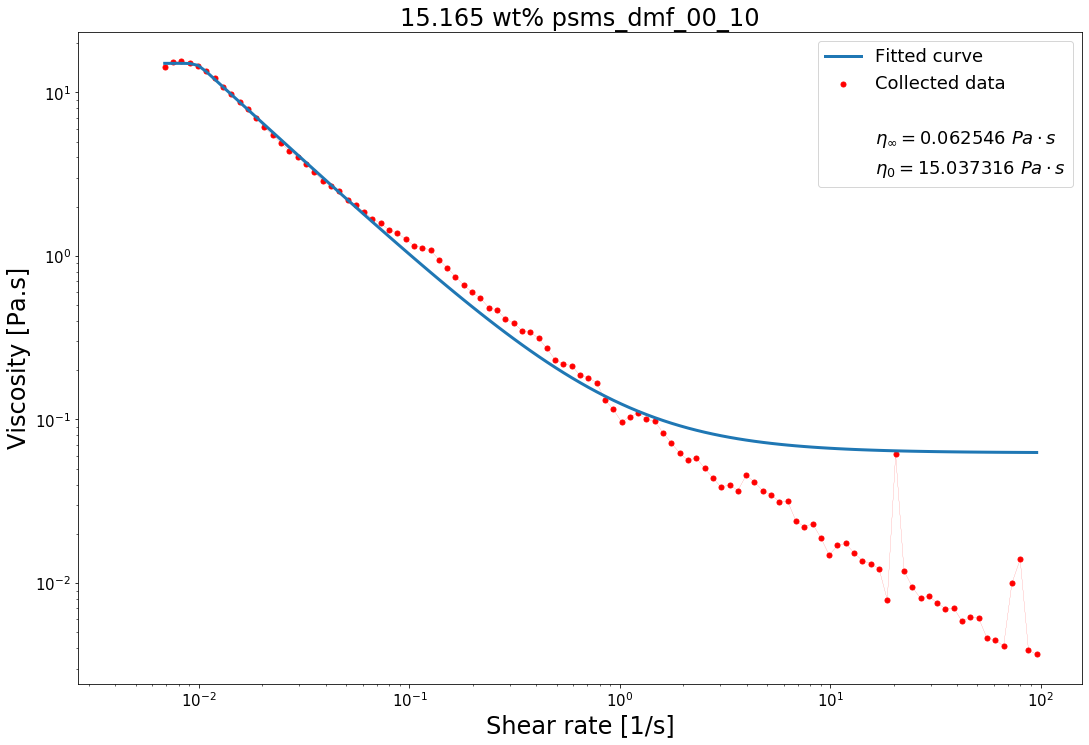

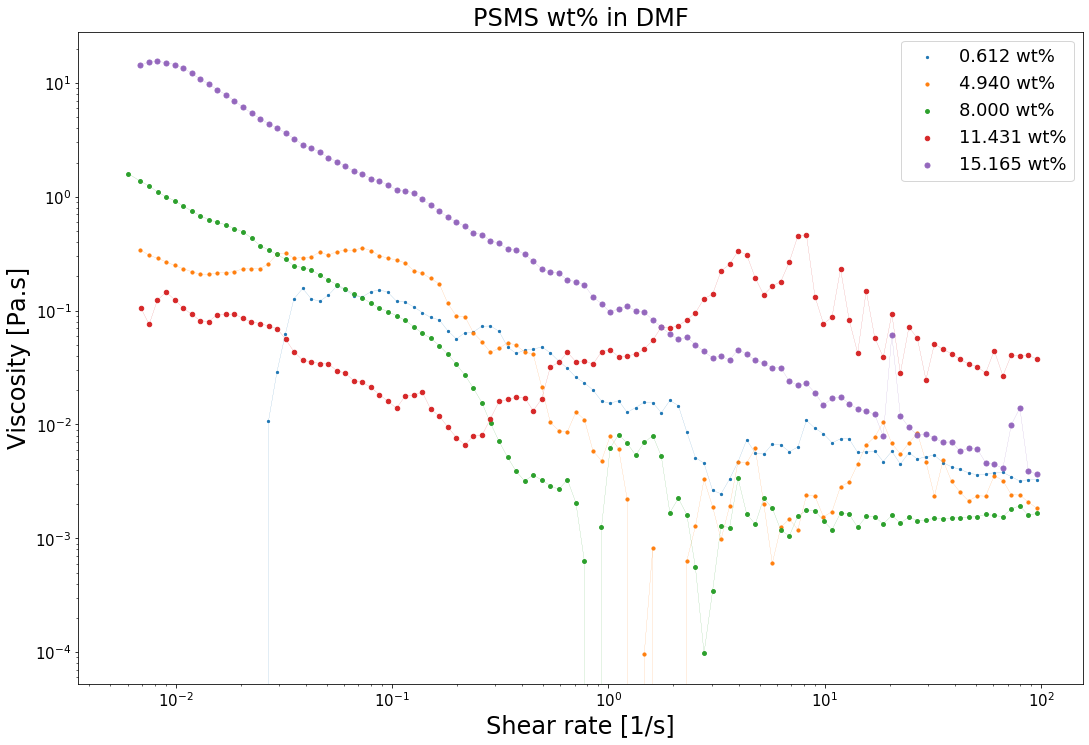

In [9]:
fit_GNF_("./csv/psms_dmf_00_6.csv",  "0.612 wt% psms_dmf_00_6",   1)
fit_GNF_("./csv/psms_dmf_00_7.csv",  "4.940 wt% psms_dmf_00_7",   1)
fit_GNF_("./csv/psms_dmf_00_8.csv",  "8.000 wt% psms_dmf_00_8",   1)
fit_GNF_("./csv/psms_dmf_00_9.csv",  "11.431 wt% psms_dmf_00_9",  1)
fit_GNF_("./csv/psms_dmf_00_10.csv", "15.165 wt% psms_dmf_00_10", 1)

compareData_("PSMS wt% in DMF",
[
    "./csv/psms_dmf_00_6.csv",
    "./csv/psms_dmf_00_7.csv",
    "./csv/psms_dmf_00_8.csv",
    "./csv/psms_dmf_00_9.csv",
    "./csv/psms_dmf_00_10.csv"
], [
    "0.612 wt%",
    "4.940 wt%",
    "8.000 wt%",
    "11.431 wt%",
    "15.165 wt%"
])

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

Stress             Pa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress      Pa
Name: 0, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

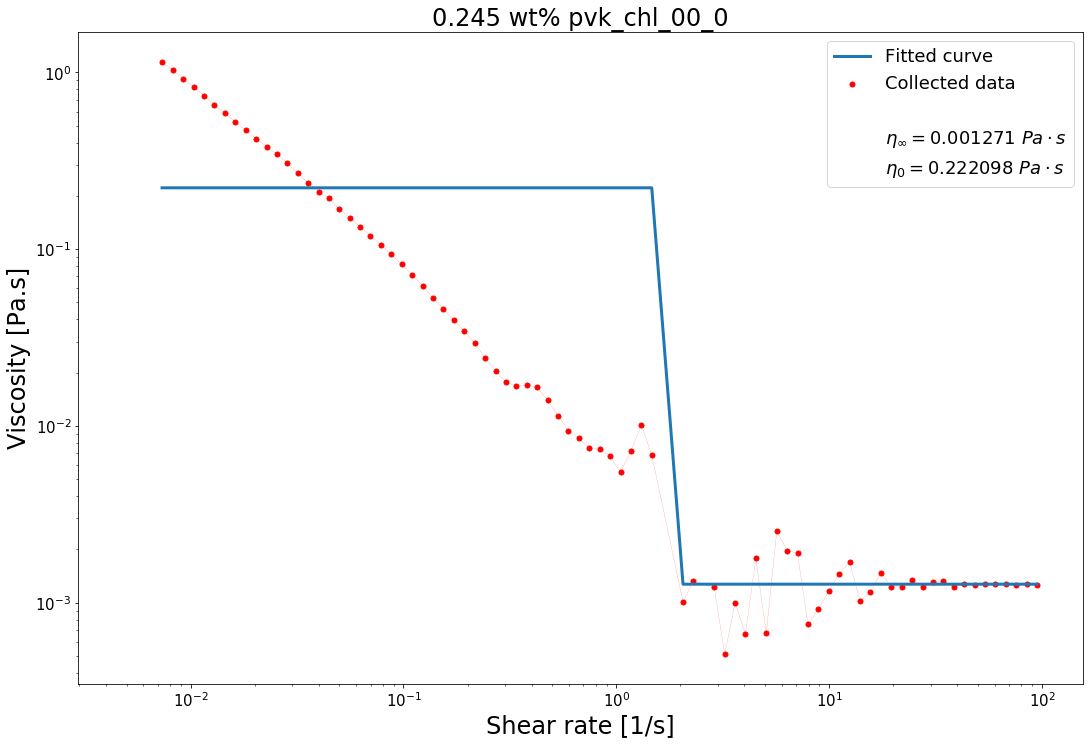

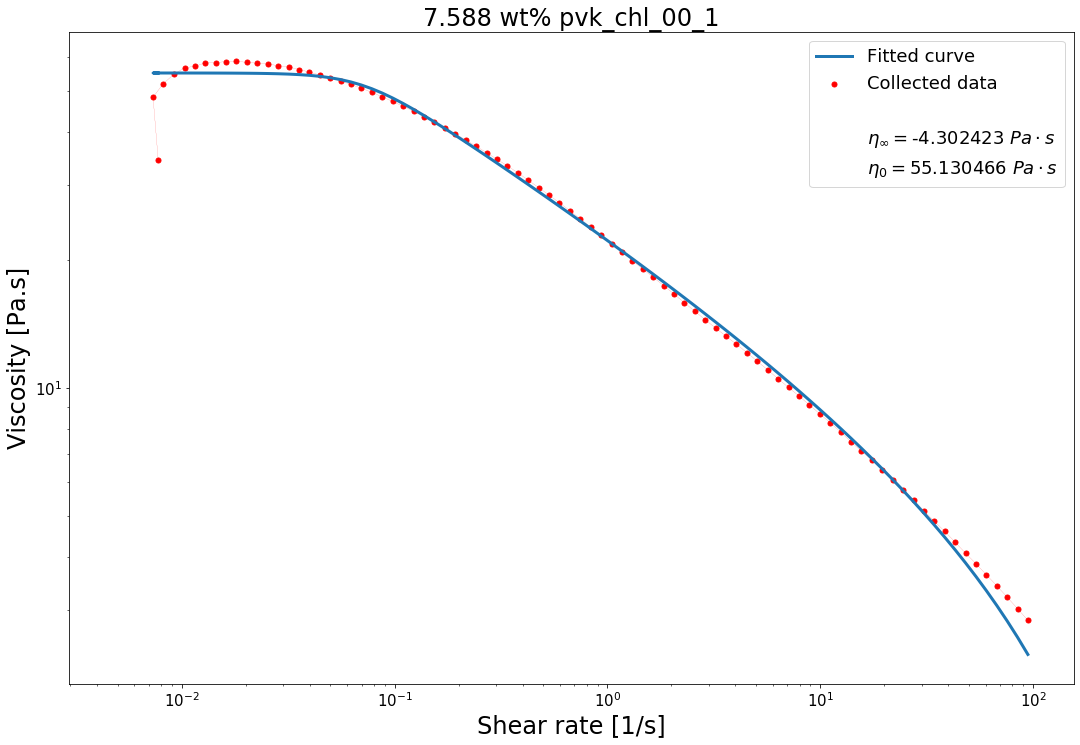

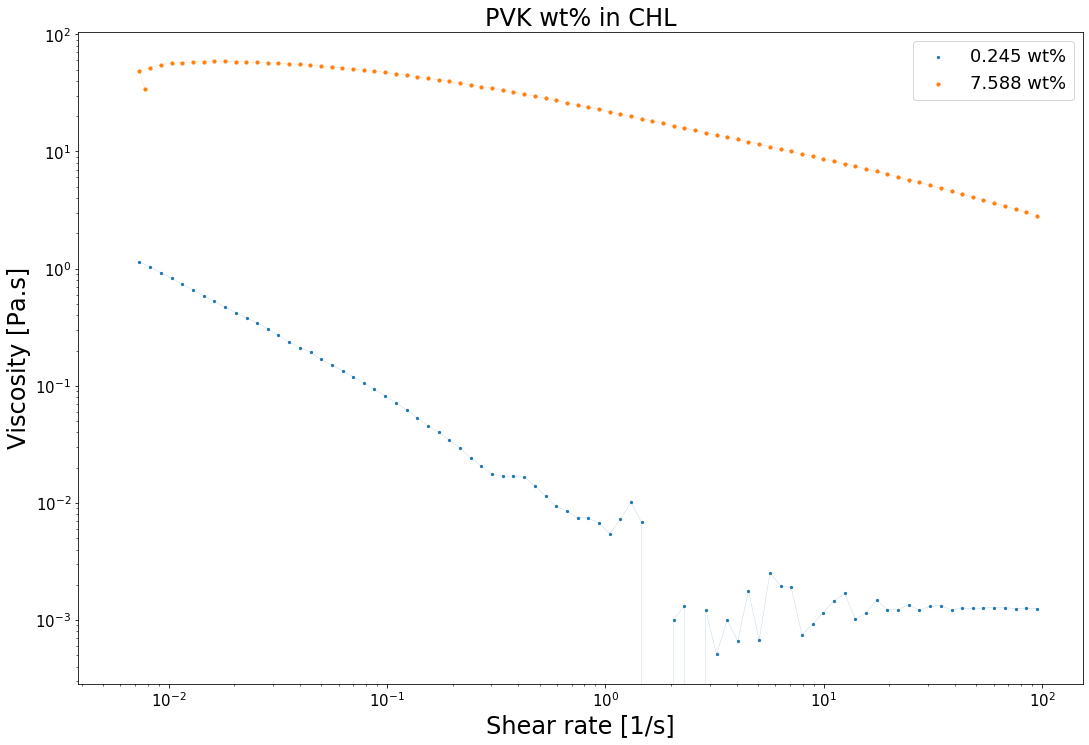

In [10]:
fit_GNF_("./csv/pvk_chl_00_0.csv", "0.245 wt% pvk_chl_00_0", 7500)
fit_GNF_("./csv/pvk_chl_00_1.csv", "7.588 wt% pvk_chl_00_1", 1)

compareData_("PVK wt% in CHL",
[
    "./csv/pvk_chl_00_0.csv",
    "./csv/pvk_chl_00_1.csv"
], [
    "0.245 wt%",
    "7.588 wt%"
])

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

Stress             Pa
Shear rate        1/s
Viscosity        Pa.s
Step time           s
Temperature        °C
Normal stress      Pa
Name: 0, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

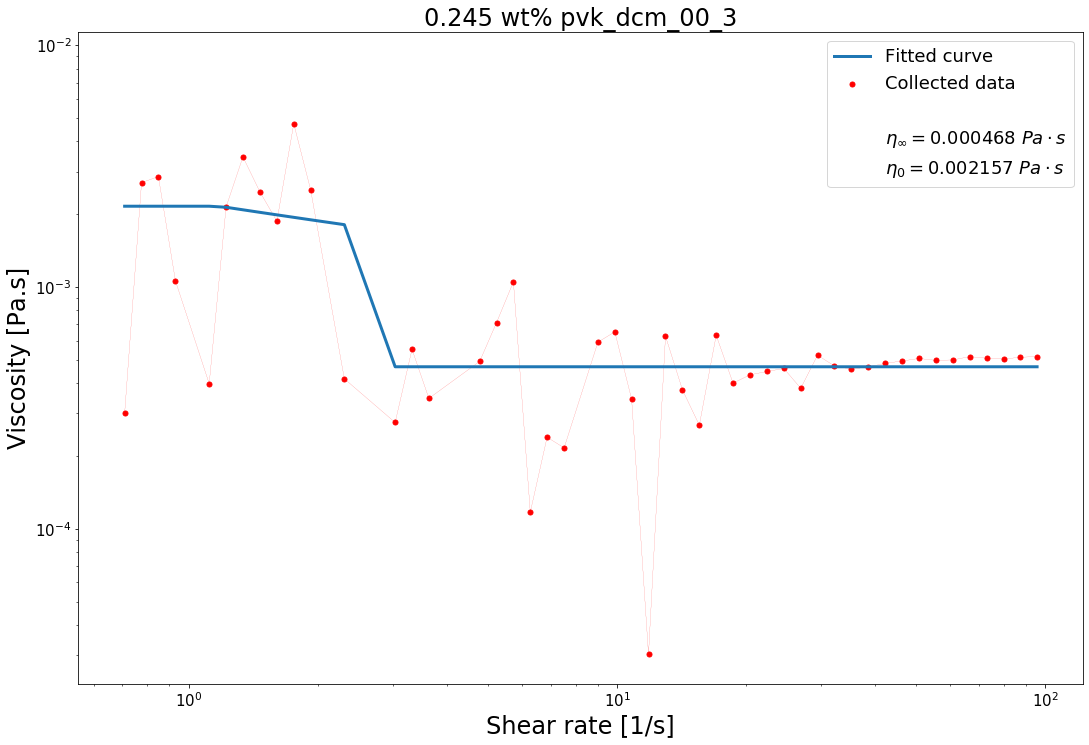

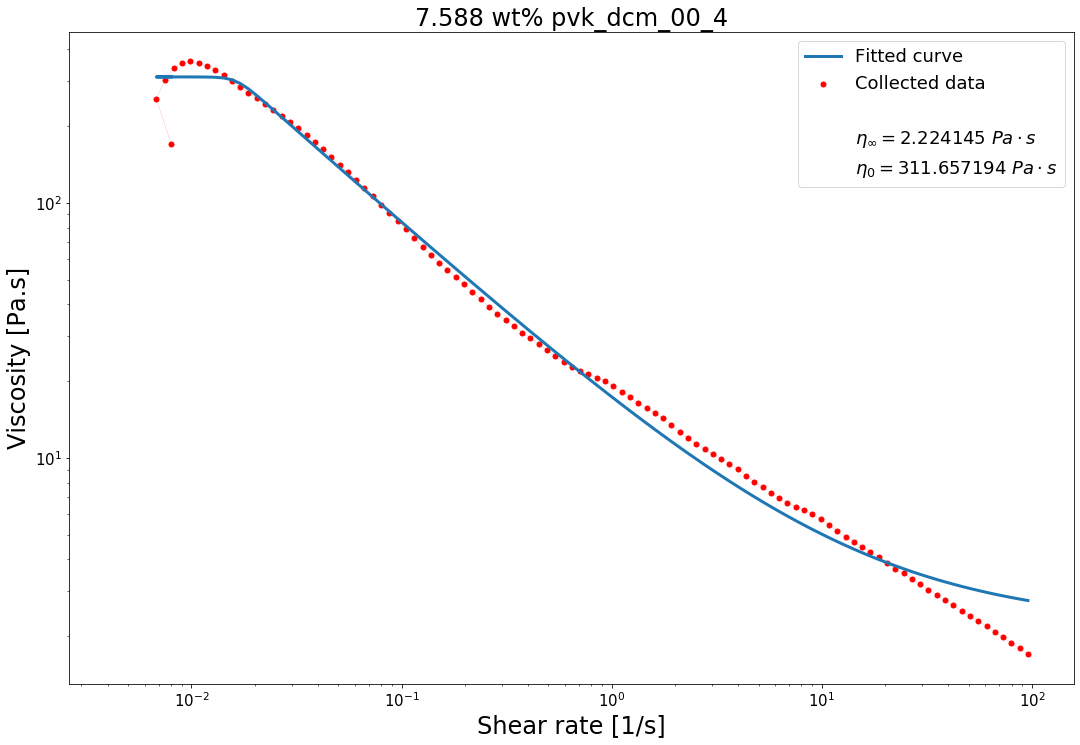

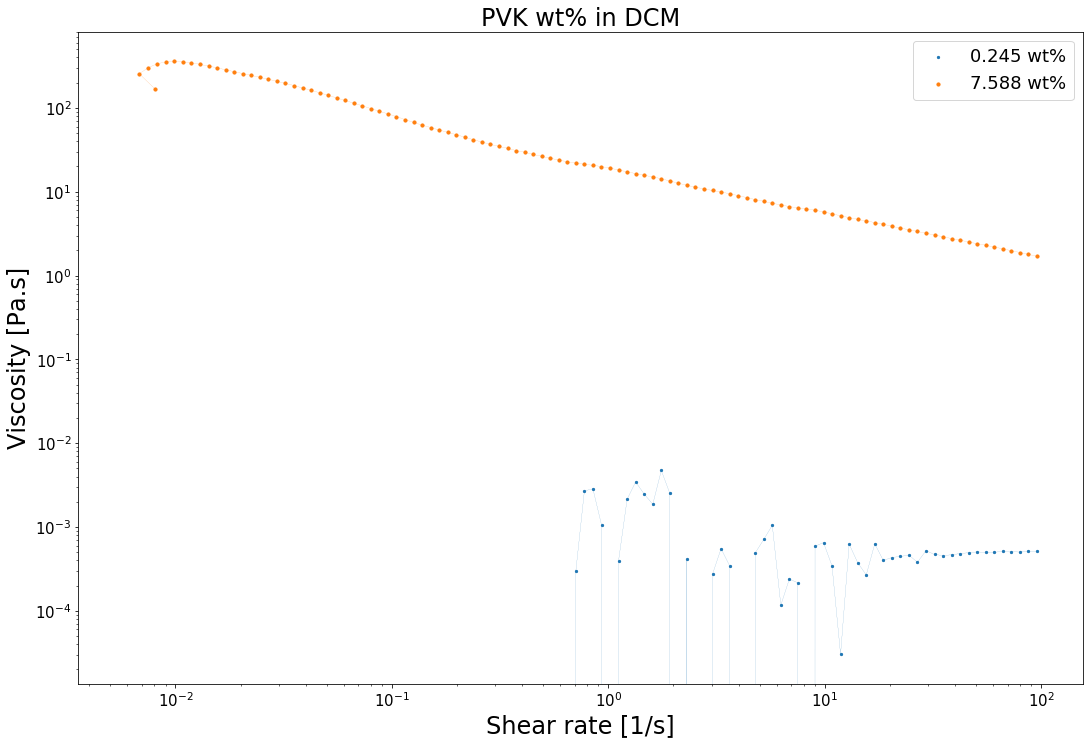

In [11]:
fit_GNF_("./csv/pvk_dcm_00_3.csv", "0.245 wt% pvk_dcm_00_3", 750)
fit_GNF_("./csv/pvk_dcm_00_4.csv", "7.588 wt% pvk_dcm_00_4", 1)

compareData_("PVK wt% in DCM",
[
    "./csv/pvk_dcm_00_3.csv",
    "./csv/pvk_dcm_00_4.csv"
], [
    "0.245 wt%",
    "7.588 wt%"
])